# Exploring Entity Co-occurrence Networks

<a target="_blank" href="https://colab.research.google.com/github/impresso/impresso-datalab-notebooks/4-impresso-py/network_graph.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## What is this notebook about?

This notebook guides you step-by-step through how to create network graphs that represent people's connections in historical newspapers. We define people's connections based on whether their names are mentioned in the same content item.

> In Impresso, a **Content Item** is the smallest unit of editorial content within a newspaper or radio collection. This can be an article (for newspapers) or a radio show or episode (for radio programs). Content items can also vary by type, including articles, advertisements, tables, images, and more. Please note that when a newspaper does not have segmentation ([OLR - Optical Layout Recognition](https://impresso-project.ch/app/faq#What-OCR)) content items for this title correspond to pages.

With this notebook, you can produce a representation of the media narratives by looking at how people have been associated to others by the press. Interpreting this association, however, can be tricky. It doesn't mean necessarily that those people have had any type of relationship. It just means that their names have been mentioned in, for example, the same news article. Understanding the reasons behind a co-occurrence typically requires further contextual or qualitative analysis. 

## What will you learn?

By completing this notebook, you will learn how to:

* Retrieve a list of persons (named entities) mentioned in content items for a given query; 
* Transform this list of entities into a dataframe suitable for generating co-occurrence network graphs; 
* Create and display an interactive network graph to visualise connections between persons mentioned together in Impresso content;
* Export the resulting dataframes as CSV files to support reproducibility;
* Save the network graph in different formats (png, svg, gexf, and json) for further analysis.

## Useful resources

If you’d like to go deeper into network analysis or its use in historical research, the following resources are recommended:

- [From Hermeneutics to Data to Networks: Data Extraction and Network Visualization of Historical Sources](https://programminghistorian.org/en/lessons/creating-network-diagrams-from-historical-sources): A conceptual and practical guide to extracting structured data from historical sources and creating meaningful network visualizations.
- [Exploring and Analyzing Network Data with Python](https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python): An introduction to working with the NetworkX package and  drawing conclusions from network metrics when working with humanities data.

Additional references:

- [Impresso Public API documentation](https://impresso-project.ch/public-api/v1/docs/) 

- [Impresso python library](https://pypi.org/project/impresso/)

- [NetworkX documentation](https://networkx.org/documentation/stable/reference/index.html)

- [ipysigma documentation](https://github.com/medialab/ipysigma)


---
## Prerequisites


Install dependencies. You may need to restart the kernel to use updated packages. To do so, on Google Colab, go to *Runtime* and select *Restart session*.

In [ ]:
%pip install -q impresso ipysigma networkx tqdm

Connect to Impresso. The following command will prompt you to enter your Impresso token if it has not been authenticated recently (it expires after 8 hours).

To get access to an Impresso API token, go to [Impresso Datalab](https://impresso-project.ch/datalab/) and select *Get API Token* on the menu.

In [2]:
from impresso import connect, OR, AND

impresso_session = connect()


Click on the following link to access the login page: https://impresso-project.ch/datalab/token
 - 🔤 Enter your email/password on this page.
 - 🔑 Once logged in, a secret token will be generated for you.
 - 📋 Copy this token and paste it into the input field below. Then press "Enter". 👇🏼.

🎉 You are now connected to the Impresso API!  🎉


# Part 1. Prepare your data

## Get entities and their co-occurrences

First, we retrieve the top 100 most frequently mentioned person entities in all articles that talk about the [Prague Spring](https://en.wikipedia.org/wiki/Prague_Spring) using search facets method from the Impresso Python library. 

> **Facets** are properties of the data. In Impresso, some facets you can use to filter articles are language, newspaper, date of publication, etc. By using search facets method, you can filter by, for example, *persons* as shown in the example below.

,count,label
value,,
aida-0001-50-Alexander_Dubček,83,Alexander Dubček
aida-0001-50-Gustáv_Husák,57,Gustáv Husák
aida-0001-50-Ota_Šik,36,Ota Šik

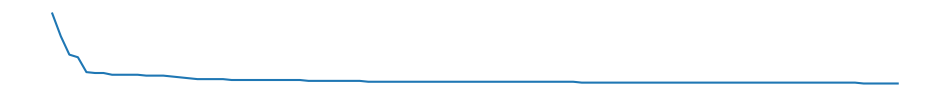

In [3]:
query = OR("Prague Spring", "Prager Frühling", "Printemps de Prague")

persons = impresso_session.search.facet(
  facet="person",
  term=query,
  order_by="-count",
  limit=100
)
persons

The result is a list of the 100 most frequently mentioned person entities, where each entry includes:

* a unique identifier (value),
* the number of times the person is mentioned (count),
* and the display name (label).

Note: these 100 entries are the most frequent out of a total of 2,355 persons mentioned in all matched content items.

Next, we generate all unique pairs of entities with a mention count higher than `n`. This will filter out pairs of entities that are mentioned just a few times. 

**Important note:** for now, we are just combining all the entities in pairs. The documents in which they occur will be found later.
 
First, entities that meet the mention threshold are selected, and then all possible pairs are generated using the `itertools.combinations` function.

The `n` value can be adjusted so that we don't get too many entity combinations. A sweet spot is just under 500 combinations. Keeping the number of combinations under 500 is typically recommended to avoid API throttling.

In [10]:
import itertools

n = 6

df = persons.df
df = df[df["count"] > n]
persons_ids = df.index.tolist()
print(f"Total persons selected: {len(persons_ids)}")

person_ids_combinations = list(itertools.combinations(persons_ids, 2))
print(f"Total combinations: {len(person_ids_combinations)}")

# The code below outputs an Exception message in case the number of combinations exceed 500. 
# If this happens to you, try to increase the value of 'n'. 

if len(person_ids_combinations) > 500:
  msg = (
      f"The number of combinations is quite high ({len(person_ids_combinations)}). " +
      "This may put a lot of load on Impresso and your requests may be throttled. " +
      "Try to increase the threshold number of mentions in the cell above which will reduce the number of selected persons. " +
      "You can also disable this error by commenting out this cell, if this number of combinations is expected."
  )
  raise Exception(msg)


Total persons selected: 30
Total combinations: 435



## Find articles where the entity pairs occur

We also retrieve the dates and the number of articles where person entity pairs occur.

This piece of code gets a facet for every combination of named entities. It is a single call per combination so it may take a while for a large number of combinations.

In [ ]:
from impresso.util.error import ImpressoError
from time import sleep
from tqdm import tqdm

connections = []

# iterate over entity combinations, and build a query from each pair, faceting on `daterange`
# the `query` variable hold the same value as above, i.e. keyword search for articles
for idx, combo in tqdm(enumerate(person_ids_combinations), total=len(person_ids_combinations)):
  try:
    result = impresso_session.search.facet(
      facet="daterange",
      term=query,
      entity_id=AND(*combo),
      limit=1000
    )
  except ImpressoError as e:
    # a 429 status code means that the request has been throttled
    # we sleep for 2 seconds and try again
    if e.error.status == 429:
      print(f"Request throttled for {combo}. Retrying in 2s...")
      sleep(2)
      try:
          result = impresso_session.search.facet(
          facet="daterange",
          term=query,
          entity_id=AND(*combo),
          limit=1000
           )
      except ImpressoError as e2:
        print(f"Retry failed for {combo}: {e2}")
      else:
        print(f"Error with {combo}: {e}")
      
  if result.size > 0:
    df = result.df

    items = list(zip(df.index.tolist(), df['count'].tolist(), [result.url for i in range(len(df))]))
    connections.append((combo, items))

100%|██████████| 435/435 [00:30<00:00, 14.04it/s]


We put all in a dataframe. Each row represents a co-occurrence event between two named persons in the Impresso dataset, for a specific date.

The dataframe includes:

* **node_a, node_b:** the unique identifiers of the co-mentioned persons;
* **timestamp:** the date of publication of the articles where they co-occurred;
* **count:** the number of articles on that date mentioning both entities;
* **url:** a direct link to the matching articles in the Impresso web app. 

In [8]:
import pandas as pd

connections_denormalised = []
for c in connections:
  nodes, edges = c

  connections_denormalised.extend(
    [[node_a, node_b, ts, count, url] for (node_a, node_b), (ts, count, url) in zip([nodes for i in range(len(edges))], edges)]
  )

connections_df = pd.DataFrame(connections_denormalised, columns=('node_a', 'node_b', 'timestamp', 'count', 'url'))
connections_df

,node_a,node_b,timestamp,count,url
0,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1968-10-02T00:00:00Z,4,https://impresso-project.ch/app/search?index=s...
1,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1969-10-02T00:00:00Z,10,https://impresso-project.ch/app/search?index=s...
2,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1973-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
3,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1974-10-02T00:00:00Z,2,https://impresso-project.ch/app/search?index=s...
4,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1977-10-02T00:00:00Z,2,https://impresso-project.ch/app/search?index=s...
...,...,...,...,...,...
193,aida-0001-50-Miloš_Forman,aida-0001-50-Alessandro_Cagliostro,1975-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
194,aida-0001-50-Miloš_Forman,aida-0001-50-Jean_Marais,1975-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
195,aida-0001-50-Paul_Lendvai,aida-0001-50-Jiří_Hájek,1976-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
196,aida-0001-50-Paul_Lendvai,aida-0001-50-Lubomír_Štrougal,1975-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...


And save the connections into a CSV file that can be visualised independently in Part 2. Here you will be prompted to provide a name for the file.

In [ ]:
from tempfile import gettempdir

temp_dir = gettempdir()

connections_csv_filename = input("Enter the filename: ").replace(" ", "_")
connections_csv_filepath = f"{temp_dir}/{connections_csv_filename}.csv"
connections_df.to_csv(connections_csv_filepath)
print(f"File saved in {connections_csv_filepath}")

## Part 2: Visualise your data 

Import the CSV file you created in Part 1

In [ ]:
import pandas as pd

connections_df = pd.read_csv(connections_csv_filepath)
connections_df

Now, we group results by frequency of pairs to create connections, and count the number of connections. We also preserve the URL. 

**Important information**: The URL does not contain DateRange information, that's why they can be grouped here as they just refer to the search terms and the pair of persons occuring in documents.

In [ ]:
grouped_connections_df = connections_df.groupby(['node_a', 'node_b']) \
    .agg({'timestamp': lambda x: ', '.join(list(x)), 'count': 'sum', 'url': lambda x: list(set(x))[0]}) \
    .reset_index()
grouped_connections_df

In the cell below, we use the [NetworkX](https://networkx.org) python library, designed for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. 

Here, we start creating our network by defining the 'source' and 'taget', as well as the edges attributes. 

In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(
    grouped_connections_df,
    source='node_a',
    target='node_b',
    edge_attr=['count', 'url'],
    create_using=nx.MultiGraph()
)
for i in sorted(G.nodes()):
    G.nodes[i]['url'] = f"https://impresso-project.ch/app/entities/{i}"
G.nodes

To ensure reprocibility, save the file so that it can be downloaded and used elsewhere.

In [ ]:
from tempfile import gettempdir

temp_dir = gettempdir()

gefx_filename = input("Enter the gefx filename: ").replace(" ", "_")
gefx_filepath = f"{temp_dir}/{gefx_filename}.gefx"

nx.write_gexf(G, gefx_filepath)

print(f"File saved in {gefx_filepath}")

If running in Colab - activate custom widgets to allow `ipysigma` to render the graph. 

Ipysigma allows you produce an interactive graph, as well as manipulate the graph's settings. 


In [ ]:
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

Run the cell below to render the graph. 

The output will prompt you to choose 'what should represent the size of the nodes' in your graph. Select it before you continue.

In [ ]:
import ipywidgets

node_size_widget = ipywidgets.Dropdown(
    options=['Degree', 'Betweenness', 'Eigenvector', 'Closeness'],
    value='Degree',
    disabled=False,
    layout={'width': 'max-content'}
)
ipywidgets.Box(
    [
        ipywidgets.Label(value='What should represent the size of the nodes:'), 
        node_size_widget
    ]
)


Refresh the next cell after changing the value above. 

This cell reads the node size method chosen above and plots the visualisation. 

In [ ]:
import networkx as nx
from ipysigma import Sigma

# Importing a gexf graph
g = nx.read_gexf(gefx_filepath)

node_size = None
# Read node size method
match node_size_widget.value:
    case 'Degree':
        node_size = g.degree
    case 'Betweenness':
        node_size = nx.betweenness_centrality(g)
    case 'Eigenvector':
        node_size = nx.eigenvector_centrality(g)
    case 'Closeness':
        node_size = nx.closeness_centrality(g)
    case _:
        node_size = g.degree

print(f"Node size method: {node_size_widget.value}.")
print("See the following link for more information about centrality measures: https://networkx.org/documentation/stable/reference/algorithms/centrality.html")

# Displaying the graph with a size mapped on degree and
# a color mapped on a categorical attribute of the nodes
Sigma(g, node_size=node_size, edge_size='count', clickable_edges=True, )

The graph display allows you to download the visualisation in png, svg, gexf, and json. 

## Conclusion

This notebook provided you with a comprehensive pipeline to create network graphs using the Impresso corpus. 

It is important to have in mind that only persons who have been tagged as entity 'persons' in the Impresso corpus will be added to this graph. Because of the way Named Entity Recognition (NER) works, it is possible that some people that are mentioned in the texts are not recognised as 'person' by the algorithms. In this case, those people will not be shown in the graph. For more information on NER, check our [FAQ](https://impresso-project.ch/app/faq#what-is-nep).

## Next Steps

That's it for now! Next, you can explore:

- the [Visualising Place Entities on Maps](https://github.com/impresso/impresso-datalab-notebooks/blob/main/annotate/NE-processing_ImpressoAPI.ipynb) notebook, which demonstrates how to visualise in a map mentions to places in the Impresso corpus.
- the [Named Entity Recognition with impresso-pipelines]() notebook, which allows you reuse Impresso NER models and apply them to your own data. 

**Also, a suggestion of other resources:**

[Introduction to Social Network Analysis](https://www.youtube.com/playlist?list=PL4iQXwvEG8CQSy4T1Z3cJZunvPtQp4dRy): Youtube tutorials by Martin Grandjean reviewing the main concepts of social network analysis, and highlighting the challenges that arise when analyzing relational historical objects.

[Demystifying Networks, Parts I & II by Scott B. Weingart](https://journalofdigitalhumanities.org/1-1/demystifying-networks-by-scott-weingart/): an older but still interesting resource with a simple introduction to networks, including concept definitions and key vocabulary

[The Six Degrees of Francis Bacon Project](http://sixdegreesoffrancisbacon.com/?ids=10000473&min_confidence=60&type=network): a DH project that reconstructs the social network of early modern intellectual life in Britain and includes publications and methodology.

[Historical Network Research Community](https://historicalnetworkresearch.org/): A hub for scholars working at the intersection of history and network analysis. Offers conference proceedings, reading lists, and tutorials.

---
## Project and License info

### Credits [CreditLogo.png](https://credit.niso.org/)


### Impresso project

[Impresso - Media Monitoring of the Past](https://impresso-project.ch) is an interdisciplinary research project that aims to develop and consolidate tools for processing and exploring large collections of media archives across modalities, time, languages and national borders. The first project (2017-2021) was funded by the Swiss National Science Foundation under grant No. [CRSII5_173719](http://p3.snf.ch/project-173719) and the second project (2023-2027) by the SNSF under grant No. [CRSII5_213585](https://data.snf.ch/grants/grant/213585) and the Luxembourg National Research Fund under grant No. 17498891.

### Copyright

Copyright (C) 2024 The Impresso team.

### License

This program is provided as open source under the [GNU Affero General Public License](https://github.com/impresso/impresso-pyindexation/blob/master/LICENSE) v3 or later.

---

<p align="center">
  <img src="https://github.com/impresso/impresso.github.io/blob/master/assets/images/3x1--Yellow-Impresso-Black-on-White--transparent.png?raw=true" width="350" alt="Impresso Project Logo"/>
</p>